### MACE counterfactual explanation for income prediction

This is an example of the Model-Agnostic Counterfactual Explanation (MACE) developed by Yang et al. If using this explainer, please cite our paper "MACE: An Efficient Model-Agnostic Framework for Counterfactual Explanation". MACE supports black-box models for classification tasks where input features can either be categorical or continuous-valued, and generates diverse counterfactual examples.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import os
import sklearn
import xgboost
import numpy as np
import pandas as pd
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import MACEExplainer

The dataset used in this example is for income prediction (https://archive.ics.uci.edu/ml/datasets/adult). We recommend using `Tabular` to represent a tabular dataset, which can be constructed from a pandas dataframe or a numpy array. To create a `Tabular` instance given a numpy array, one needs to specify the data, the feature names, the categorical feature names (if exists) and the target/label column name (if exists).

In [3]:
feature_names = [
    "Age", "Workclass", "fnlwgt", "Education",
    "Education-Num", "Marital Status", "Occupation",
    "Relationship", "Race", "Sex", "Capital Gain",
    "Capital Loss", "Hours per week", "Country", "label"
]
data = np.genfromtxt(os.path.join('../data', 'adult.data'), delimiter=', ', dtype=str)
tabular_data = Tabular(
    data,
    feature_columns=feature_names,
    categorical_columns=[feature_names[i] for i in [1, 3, 5, 6, 7, 8, 9, 13]],
    target_column='label'
)
print(tabular_data)

      Age         Workclass  fnlwgt   Education Education-Num  \
0      39         State-gov   77516   Bachelors            13   
1      50  Self-emp-not-inc   83311   Bachelors            13   
2      38           Private  215646     HS-grad             9   
3      53           Private  234721        11th             7   
4      28           Private  338409   Bachelors            13   
...    ..               ...     ...         ...           ...   
32556  27           Private  257302  Assoc-acdm            12   
32557  40           Private  154374     HS-grad             9   
32558  58           Private  151910     HS-grad             9   
32559  22           Private  201490     HS-grad             9   
32560  52      Self-emp-inc  287927     HS-grad             9   

           Marital Status         Occupation   Relationship   Race     Sex  \
0           Never-married       Adm-clerical  Not-in-family  White    Male   
1      Married-civ-spouse    Exec-managerial        Husband  Wh

`TabularTransform` is a special transform designed for tabular data. By default, it converts categorical features into one-hot encoding, and keeps continuous-valued features (if one wants to normalize continuous-valued features, set the parameter `cont_transform` in `TabularTransform` to `Standard` or `MinMax`). The `transform` method of `TabularTransform` will transform a `Tabular` instance into a numpy array. If the `Tabular` instance has a target/label column, the last column of the transformed numpy array will be the target/label. 

If some other transformations that are not supported in the library are necessary, one can simply convert the `Tabular` instance into a pandas dataframe by calling `Tabular.to_pd()` and try different transformations with it.

After data preprocessing, we can train a XGBoost classifier for this task (one may try other classifiers). 

In [4]:
np.random.seed(1)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)
train, test, labels_train, labels_test = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
gbtree.fit(train, labels_train)
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(labels_test, gbtree.predict(test))))

Training data shape: (26048, 108)
Test data shape:     (6513, 108)
Test accuracy: 0.8668816213726394


The prediction function takes a `Tabular` instance as its inputs, and outputs the class probabilities or logits for classification tasks or the estimated values for regression tasks. In this example, we simply call `transformer.transform` to do data preprocessing followed by the prediction function of `gbtree`.

In [5]:
predict_function=lambda z: gbtree.predict_proba(transformer.transform(z))

To initialize a MACE explainer, we need to set:
  
  - `training_data`: The data used to initialize a MACE explainer. ``training_data`` can be the training dataset for training the machine learning model. If the training dataset is too large, ``training_data`` can be a subset of it by applying `omnixai.sampler.tabular.Sampler.subsample`.
  - `predict_function`: The prediction function corresponding to the model.
  - `ignored_features`: The features ignored in generating counterfactual examples, i.e., those features are fixed.
  
In this example, we set `ignored_features=["Sex", "Race", "Relationship", "Capital Loss"]`, meaning that the generated counterfactual examples don't change the values of these features.

In [6]:
explainer = MACEExplainer(
    training_data=tabular_data,
    predict_function=predict_function,
    ignored_features=["Sex", "Race", "Relationship", "Capital Loss"]
)
test_instances = tabular_data.remove_target_column()[0:5]

MACE generates local explanations, e.g. `explainer.explain` is called given the test instances. `ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance to plot, e.g., `index = 1` means plotting the second instance in `test_instances`.

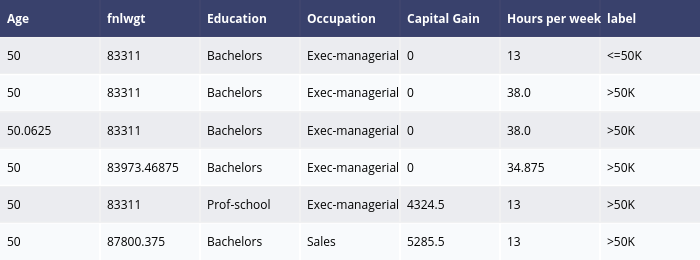

In [7]:
explanations = explainer.explain(test_instances)
explanations.ipython_plot(index=1, class_names=class_names)